In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.linalg import sqrtm



In [250]:
goog = yf.Ticker('GOOG')
data = goog.history(period='3mo')
display(data)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-01-17 00:00:00-05:00,92.779999,92.970001,90.839996,92.160004,22935800,0.0,0.0
2023-01-18 00:00:00-05:00,92.940002,93.587997,91.400002,91.779999,19641600,0.0,0.0
2023-01-19 00:00:00-05:00,91.389999,94.400002,91.379997,93.910004,28707700,0.0,0.0
2023-01-20 00:00:00-05:00,95.949997,99.419998,95.910004,99.279999,53704800,0.0,0.0
2023-01-23 00:00:00-05:00,99.129997,101.400002,98.750000,101.209999,31791800,0.0,0.0
...,...,...,...,...,...,...,...
2023-04-10 00:00:00-04:00,107.389999,107.970001,105.599998,106.949997,19741500,0.0,0.0
2023-04-11 00:00:00-04:00,106.919998,107.220001,105.279999,106.120003,18721300,0.0,0.0
2023-04-12 00:00:00-04:00,107.389999,107.586998,104.970001,105.220001,22761600,0.0,0.0


In [251]:
average_daily_volume = np.mean(data['Volume'])
average_daily_spread = np.mean(data['High'] - data['Low'])
sigma = np.std(data['Close']) * np.sqrt(4)
epsilon = average_daily_spread/2
eta = average_daily_spread/(0.01*average_daily_volume)
gamma = average_daily_spread/(0.1*average_daily_volume)
tau = 1

params = {
    'lambda': 1e-08,
    'sigma': sigma,
    'epsilon': epsilon,
    'eta': eta,
    'gamma': gamma,
    'tau': tau
}

print('Parameters:')
for k,v in params.items():
    print('  {} = {}'.format(k,v))

Parameters:
  lambda = 1e-08
  sigma = 11.601605656781848
  epsilon = 1.3118868797056136
  eta = 8.147797195051261e-06
  gamma = 8.14779719505126e-07
  tau = 1


In [252]:
class AlmgrenChriss1D:
    
    def __init__(self, params):
        # Initialize Parameters
        self._lambda = params['lambda']
        self._sigma = params['sigma']
        self._epsilon = params['epsilon']
        self._eta = params['eta']
        self._gamma = params['gamma']
        self._tau = params['tau']
        
        self._eta_tilda = self._eta - 0.5*self._gamma*self._tau
        
        # Ensure Quadratic (for optimization)
        assert self._eta_tilda > 0
        
        self._kappa_tilda_squared = (self._lambda*self._sigma**2)/self._eta_tilda
        
        self._kappa = np.arccosh(0.5*(self._kappa_tilda_squared*self._tau**2) + 1)/self._tau
        
    def trajectory(self, X, T):
        # Optimal Liquidation Trajectory
        ans = []
        for t in range(T):
            x = int(np.sinh(self._kappa*(T - t))/np.sinh(self._kappa*T)*X)
            ans.append(x)
        ans.append(0)
        return np.array(ans)
    
    def strategy(self, X, T):
        # Optimal Liquidation Trade List
        return np.diff(self.trajectory(X,T))

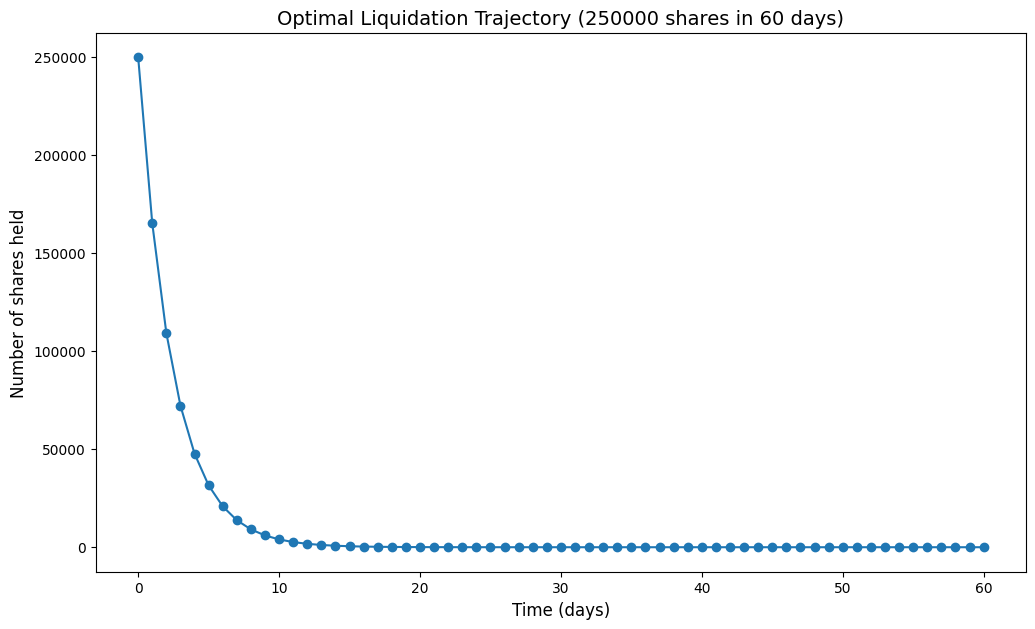

In [253]:
X = 250000
T = 60

model = AlmgrenChriss1D(params)
trajectory = model.trajectory(X,T)

plt.figure(figsize=(12,7))
plt.plot(range(T+1),trajectory,'o-')
plt.title(f'Optimal Liquidation Trajectory ({X} shares in {T} days)',fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.show()



In [254]:
trajectory
diff_trajectory = np.diff(trajectory)*-1
diff_trajectory
price_array = np.array(data["Close"][:-2])
price_array
diff_trajectory

array([84756, 56022, 37029, 24475, 16178, 10693,  7068,  4671,  3088,
        2041,  1349,   892,   589,   390,   257,   171,   112,    75,
          49,    32,    22,    14,     9,     6,     5,     2,     2,
           1,     1,     0,     1,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0])

In [258]:
initial_holding_value = X*data["Close"].iloc[0]
end_holding_value = np.sum(price_array*diff_trajectory)
shortfall = end_holding_value - initial_holding_value 
shortfall
end_holding_value
initial_holding_value-end_holding_value

-583490.5659561157